<a href="https://colab.research.google.com/github/laurence-lin/Kaggle_competition/blob/master/Ashrae_predict_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import math

import sklearn
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import os

import gc
from google.colab import files
# load data from Cloud Storage
from google.colab import auth
auth.authenticate_user()

# Configure GCP project and use gsutil to copy the file from storage

!gcloud config set project 'blind-detection'
!gsutil -m cp -r gs://ashare_dataset/*.csv  sample_data/



# Reduce memory function

# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
# Modified to support timestamp type, categorical type
# Modified to add option to use float16


from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.        
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    
    return df


# Load all datasets and reduce memory
print(os.listdir('sample_data/'))
data_path = 'sample_data/'
train = pd.read_csv(os.path.join(data_path, 'train.csv'), parse_dates = ['timestamp'])
test = pd.read_csv(os.path.join(data_path, 'test.csv'), parse_dates = ['timestamp'])
building = pd.read_csv(os.path.join(data_path, 'building_metadata.csv'))
weather_test = pd.read_csv(os.path.join(data_path, 'weather_test.csv'), parse_dates = ['timestamp'])
#submission = pd.read_csv(os.path.join(data_path, 'sample_submission.csv'))
weather_train = pd.read_csv(os.path.join(data_path, 'weather_train.csv'), parse_dates = ['timestamp'])

train = reduce_mem_usage(train, use_float16 = True)
building = reduce_mem_usage(building, use_float16 = True)
weather_train = reduce_mem_usage(weather_train, use_float16 = True)
test = reduce_mem_usage(test)
weather_test = reduce_mem_usage(weather_test)




Updated property [core/project].


To take a quick anonymous survey, run:
  $ gcloud survey

Copying gs://ashare_dataset/building_metadata.csv...
Copying gs://ashare_dataset/train.csv...
Copying gs://ashare_dataset/test.csv...
Copying gs://ashare_dataset/sample_submission.csv...
Copying gs://ashare_dataset/weather_test.csv...
Copying gs://ashare_dataset/weather_train.csv...
| [6/6 files][  2.4 GiB/  2.4 GiB] 100% Done  41.9 MiB/s ETA 00:00:00           
Operation completed over 6 objects/2.4 GiB.                                      
['anscombe.json', 'README.md', 'weather_train.csv', 'sample_submission.csv', 'building_metadata.csv', 'test.csv', 'train.csv', 'weather_test.csv', 'california_housing_test.csv', 'mnist_test.csv', 'mnist_train_small.csv', 'california_housing_train.csv']
Memory usage of dataframe is 616.95 MB
Memory usage after optimization is: 289.19 MB
Decreased by 53.1%
Memory usage of dataframe is 0.07 MB
Memory usage after optimization is: 0.02 MB
Decreased by 73.8%
Mem

In [4]:
# EDA: Data Analysis

# Training data: 
# train: data for each building meter readings, at each timestamp for each building
# building: data for each building meta data, at each location
# weather_train: weather at each location, at each location

# Test data: test, building, weather_test

# Prediction target: meter_reading 
print('Train file information: ')
print(train.info())


Train file information: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
building_id      int16
meter            int8
timestamp        datetime64[ns]
meter_reading    float32
dtypes: datetime64[ns](1), float32(1), int16(1), int8(1)
memory usage: 289.2 MB
None


In [5]:
print('Building meta data structure: ')
print(building.info())

Building meta data structure: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
site_id        1449 non-null int8
building_id    1449 non-null int16
primary_use    1449 non-null category
square_feet    1449 non-null int32
year_built     675 non-null float16
floor_count    355 non-null float16
dtypes: category(1), float16(2), int16(1), int32(1), int8(1)
memory usage: 17.9 KB
None


In [6]:
print('Training weather data structure: ')
print(weather_train.info())

Training weather data structure: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
site_id               139773 non-null int8
timestamp             139773 non-null datetime64[ns]
air_temperature       139718 non-null float16
cloud_coverage        70600 non-null float16
dew_temperature       139660 non-null float16
precip_depth_1_hr     89484 non-null float16
sea_level_pressure    129155 non-null float16
wind_direction        133505 non-null float16
wind_speed            139469 non-null float16
dtypes: datetime64[ns](1), float16(7), int8(1)
memory usage: 3.1 MB
None


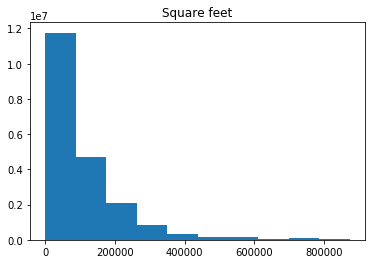

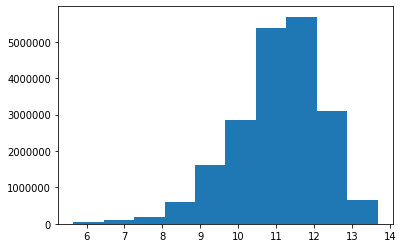

In [0]:
# EDA: Data analysis


# Observe target distribution

plt.scatter(range(train.shape[0]), np.sort(train['meter_reading'].values))
plt.xlabel('Index of all measurements')
plt.ylabel('Meter Reading Values')
plt.title('Target Distributions: Increasing')
plt.show()


#plt.plot(train['meter_reading'])
plt.hist(train['meter_reading'], 
         bins = 25, #number of histograms to show up
         )
plt.show()


# Observe missing values or zeros
# train data
# Should deal with missing values here
def check_missing(df):
  total = df.isnull().sum().sort_values(ascending = False) # missing values in each feature
  percent = total / df.shape[0] * 100 # percentage of missing values in each feature
  missing_in_data = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percentage'])
  print(missing_in_data)

#print('Training missing: \n')
#check_missing(train)

print('Weather train missing: \n')
check_missing(weather_train)

print('Weather test missing: \n')
check_missing(weather_test)

print('Building meta missing: \n')
check_missing(building)

# Check feature correlation with target
# Should do feature selection here
corr_ = train.corr(method = 'pearson')
print('Most positive correlations:\n', corr_['meter_reading'].sort_values(ascending = False))
import seaborn as sns
sns.heatmap(corr_,
            annot = True, # write data value in each cell 
            cmap = plt.cm.RdYlBu_r, # set the color map 
            vmin = -0.25)
plt.title('Correlation heatmap')



# Show numerical feature distribution
# Should do feature transformation or processing

def plot_dist_curve(column):
  
  #Plot dist curve for weather_train & test data for given column name
  
  # I don't see the advantage dist better than hist
  fig, ax = plt.subplots(figsize = [10, 10]) # ax contains the figure elements
  sns.distplot(weather_train[column].dropna(), ax = ax).set_title(column)
  sns.distplot(weather_test[column].dropna(), ax = ax)
  plt.xlabel(column, fontsize = 15)
  plt.legend(['train', 'test']) # legend show by order of plot
  plt.show()

#plot_dist_curve('air_temperature')

# Outlier distribution
# Should detect outlier and abandon the outliers from dataset
# Outlier: the outlier of (mean value of all meter readings along the timestamp)
fig1, ax1 = plt.subplots()
y_mean_eachtime = train.groupby('timestamp').meter_reading.mean() # plot the mean value of all meter sensors in each time date
print(type(y_mean_eachtime))
#plt.plot(y_mean_eachtime.values)
y_mean_eachtime.plot(figsize = (20, 8), ax = ax1)

y_mean_eachtime.rolling(window = 10).std().plot(figsize = (20, 8))
ax1.axhline(y = .009, color = 'red')
ax1.legend(['Mean value of meter_reading each date', 'std of 10 date', 'horizontal'])
'''
'''
#print(weather_train.isnull().sum())
#print(building.isnull().sum())
temp = train.merge(building, on = 'building_id', how = 'left')
show = temp.groupby('primary_use').size().reset_index(name = 'count')
plt.figure()
ax = sns.barplot(show['primary_use'], show['count'])
ax.set_xticklabels(ax.get_xticklabels(), rotation = 50, ha = 'right')
del temp

print('Meter type distribution: ')
show_ = train.groupby('meter').size().reset_index(name = 'count')
plt.figure(2)
ax2 = sns.barplot(show_['meter'], show_['count'])


#temp = train.merge(building, on = 'building_id', how = 'left')
#temp = temp.merge(weather_train, on = ['site_id', 'timestamp'], how = 'left')
plt.figure(1)
plt.hist(temp['square_feet'])
plt.title('Square feet')

square_ = np.log1p(temp['square_feet'])
plt.figure(2)
plt.hist(square_)


plt.show()
'''

As to training data, I've about 1448 buildings to predict. 
Time scan over 3 years, each day as time step. 

Now should we rearrange the data? Each building locate in single site.
Assumption to rearrange:
1. Sort by building_id
2. Sort by time_stamp

Feature engineering:
Data cleaning: delete useless column
Data processing: standardization
Feature engineering: create new features